In [1]:
import re  # for string splitting
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import cvlib as cv
import pandas as pd
import os
from cvlib.object_detection import draw_bbox
import datetime
from ipywidgets import *
import scipy.stats as st
from scipy import signal

from matplotlib.colors import LogNorm
from matplotlib.colors import DivergingNorm

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from scipy.signal import savgol_filter

Using TensorFlow backend.


In [21]:
def gkern_2(kernlen=34, nsig=5.5):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

def gkern(kernlen=34, nsig=5.5):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=nsig).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d


def gkern_1d(kernlen=34, nsig=5.5):
    """Returns a 1D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    return kern1d/kern1d.sum()


def kernel_from_d(d_um=2.2, scaling_factor=0.345):
    '''
    d_um=2.2 # micrometer, smallest feature we want to detect
    scaling_factor=0.345 #pixela/um
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=2*np.ceil(3*sigma)
    '''
    d = d_um/scaling_factor  # d in pixels
    # estimate of a good sigma to use Guesebroek et al.
    sigma = d*0.5*np.sqrt(3)
    #print(sigma)
    cutoff = int(2*np.ceil(3*sigma)+1)
    #print(cutoff)
    kernel = np.array(gkern(kernlen=cutoff, nsig=sigma))

    return kernel, sigma, cutoff


def kernel_from_d_1d(d_um=2.2, scaling_factor=0.345):
    '''
    d_um=2.2 # micrometer, smallest feature we want to detect
    scaling_factor=0.345 #pixela/um
    d=d_um/scaling_factor #d in pixels
    sigma=d*0.5*np.sqrt(3) # estimate of a good sigma to use Guesebroek et al.
    cutoff=2*np.ceil(3*sigma)
    '''
    d = d_um/scaling_factor  # d in pixels
    # estimate of a good sigma to use Guesebroek et al.
    sigma = d*0.5*np.sqrt(3)
    cutoff = int(2*np.ceil(3*sigma)+1)

    kernel = np.array(gkern_1d(kernlen=cutoff, nsig=sigma))

    return kernel, sigma, cutoff


def plot_kernel_nice(kernel, ax):
    plot = ax.imshow(kernel, cmap='RdBu', norm=DivergingNorm(0))
    plt.colorbar(plot, ax=ax)
    return ax

In [22]:
check_function_forwarding = False

if check_function_forwarding:
    plt.figure()
    kernel_2d_gkern = gkern(kernlen=35, nsig=5.5)
    plot1 = plt.imshow(kernel_2d_gkern, cmap='gray')
    plt.colorbar(plot1)

    plt.figure()
    kernel_2d, sigma, cutoff = kernel_from_d()
    plot2 = plt.imshow(kernel_2d, cmap='gray')
    plt.colorbar(plot2)

    plt.figure()

    kernel_gkern = gkern_1d(kernlen=35, nsig=5.5)
    plt.plot(kernel_gkern)

    plt.figure()
    kernel, sigma, cutoff = kernel_from_d_1d()
    plt.plot(kernel, c='black')

<Figure size 432x288 with 0 Axes>

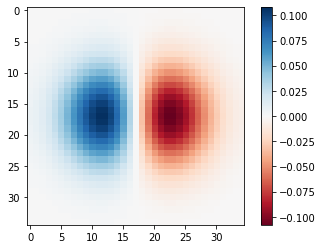

<Figure size 432x288 with 0 Axes>

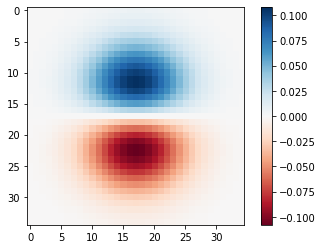

In [23]:
show_kernels = True
if show_kernels:
    plt.figure()
    kernel_2d, sigma, cutoff = kernel_from_d(d_um=2.2)
    g_gradient_x = np.gradient(kernel_2d, axis=1)

    plt.figure()
    ax = plt.gca()
    plot_kernel_nice(g_gradient_x, ax)

    plt.figure()
    kernel_2d, sigma, cutoff = kernel_from_d()
    g_gradient_y = np.gradient(kernel_2d, axis=0)

    plt.figure()
    ax = plt.gca()
    plot_kernel_nice(g_gradient_y, ax)

/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Results_200311/Scans/minus_3_04-03112020115915-0.png_2_x460_y930_r28_cut2.png
/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Illuminations/Diffusor/255kHz_48ulpermin-06012020110251-0.png
metric is 5943.266680717468
metric is 5943.266680717468


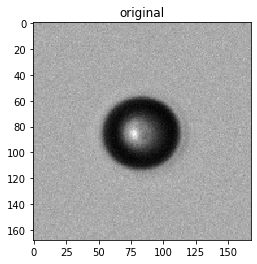

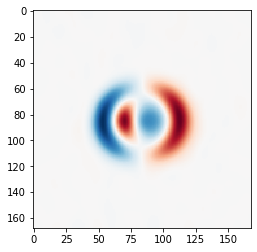

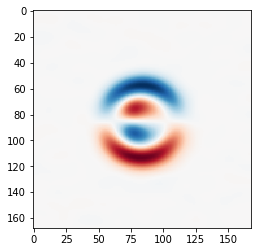

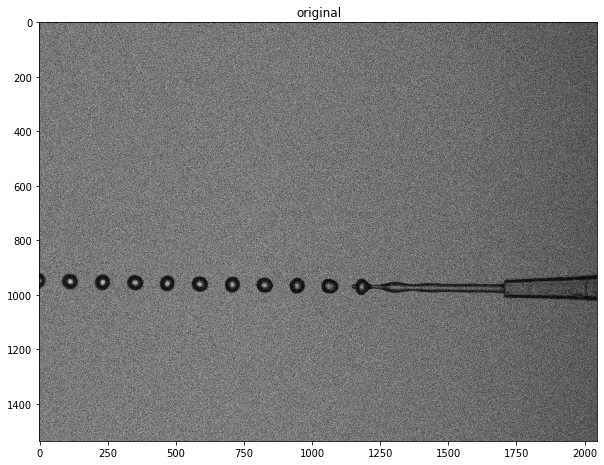

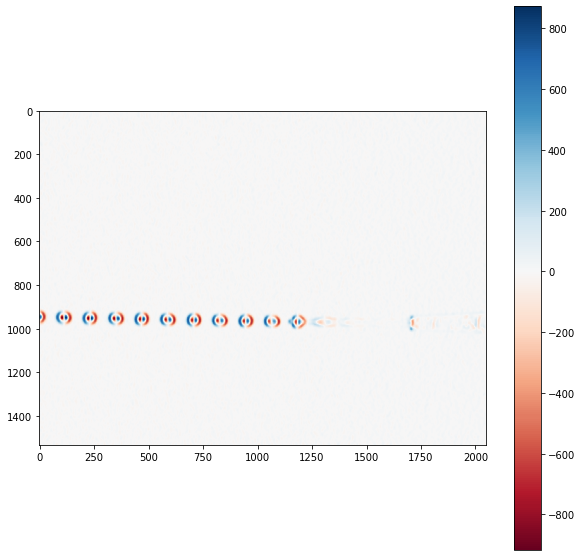

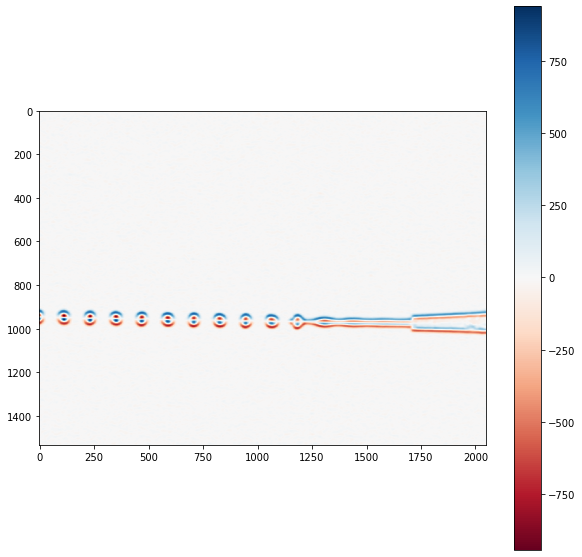

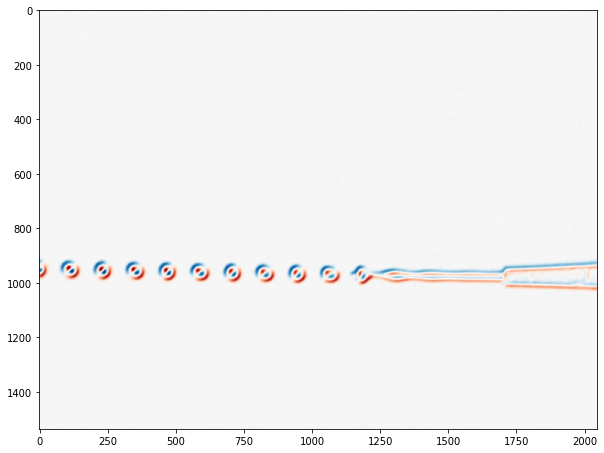

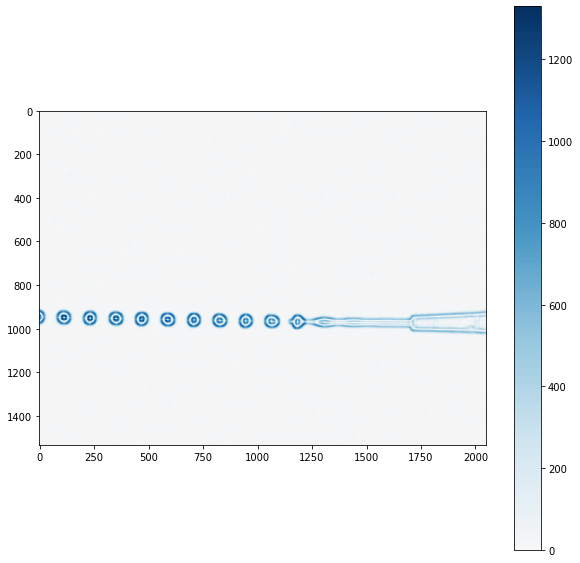

In [24]:
test_kernels = True
if test_kernels:
    PATH = os.path.join(os.getcwd(), 'Results_200311/Scans')
    file_name = 'minus_3_04-03112020115915-0.png_2_x460_y930_r28_cut2.png'

    path_to_image = os.path.join(PATH, file_name)
    print(path_to_image)

    image = cv2.imread(path_to_image)
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.figure()
    plt.imshow(src, cmap='gray')
    plt.title('original')

    plt.figure()

    kernel_2d, sigma, cutoff = kernel_from_d(d_um=2.2)

    g_gradient_x = np.gradient(kernel_2d, axis=1)

    # ,ddepth=cv2.CV_32S)
    filtered = cv2.filter2D(src, cv2.CV_16S, g_gradient_x)
    plt.imshow(filtered, cmap='RdBu', norm=DivergingNorm(0))

    plt.figure()

    kernel_2d, sigma, cutoff = kernel_from_d(d_um=2.2)

    g_gradient_y = np.gradient(kernel_2d, axis=0)

    # ,ddepth=cv2.CV_32S)
    filtered = cv2.filter2D(src, cv2.CV_16S, g_gradient_y)
    plt.imshow(filtered, cmap='RdBu', norm=DivergingNorm(0))

test_real_image = True
if test_real_image:
    figsize = [10, 10]

    PATH = '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Illuminations/'
    file_name = 'Diffusor/255kHz_48ulpermin-06012020110251-0.png'
    # file_name='Diffusor/255kHz_48ulpermin-06012020112137-58.png'
    # file_name='Medium_hole/255kHz_48ulpermin-06012020122747-5.png'
    # file_name='Medium_hole/255kHz_48ulpermin-06012020122750-15.png'

    path_to_image = os.path.join(PATH, file_name)
    print(path_to_image)

    image = cv2.imread(path_to_image)
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=figsize)
    plt.imshow(src, cmap='gray')
    plt.title('original')

    plt.figure(figsize=figsize)

    kernel_2d, sigma, cutoff = kernel_from_d(d_um=2.2)

    g_gradient_x = np.gradient(kernel_2d, axis=1)

    # ,ddepth=cv2.CV_32S)
    filtered_x = cv2.filter2D(src, cv2.CV_32S, g_gradient_x)
    plt.imshow(filtered_x, cmap='RdBu', norm=DivergingNorm(0))
    plt.colorbar()
    plt.figure(figsize=figsize)

    kernel_2d, sigma, cutoff = kernel_from_d(d_um=2.2)

    g_gradient_y = np.gradient(kernel_2d, axis=0)

    # ,ddepth=cv2.CV_32S)
    filtered_y = cv2.filter2D(src, cv2.CV_32S, g_gradient_y)
    plt.imshow(filtered_y, cmap='RdBu', norm=DivergingNorm(0))
    plt.colorbar()

    plt.figure(figsize=figsize)
    plt.imshow(filtered_x+filtered_y, cmap='RdBu', norm=DivergingNorm(0))

    plt.figure(figsize=figsize)
    plt.imshow(np.abs(filtered_x)+np.abs(filtered_y),
               cmap='RdBu', norm=DivergingNorm(0))
    plt.colorbar()

metric = np.divide(
    np.sum(np.add(np.square(filtered_x), np.square(filtered_y))), src.size)
print('metric is ' + str(metric))

filtered = np.add(np.square(filtered_x), np.square(filtered_y))
metric = np.divide(np.sum(filtered), src.size)
print('metric is ' + str(metric))

In [46]:
def GD_metric(in_img, d_um=2.2, scaling_factor=0.345,g_gradient_x=None, g_gradient_y=None):
    '''input img in openCV format
    d_um is smallest feature detectable in image (resolution)
    g_gradient_x if provided is the kernel used in x, otherwise calculated from d_um
    g_gradient_y if provided is the kernel used in y, otherwise calculated from d_um

    return metric, filtered
    Method from 

    Shah et. al, Identification of Robust Focus Measure Functions for the Automated Capturing of Focused Images from
     Ziehl-Neelsen Stained Sputum Smear Microscopy Slide

     and 

    Geusebroek et. al, Robust Autofocusing in Microscopy

    code written and developed by H.Olof Jönsson 2020, please 
    credit (whatever paper we make) if using the code directly
    '''

    src = cv2.cvtColor(in_img, cv2.COLOR_BGR2GRAY)  # grayscale conversion
    # calculate kernel for x
    if g_gradient_x == None:
        kernel_2d, sigma, cutoff = kernel_from_d(d_um=d_um,scaling_factor=scaling_factor)
        g_gradient_x = np.gradient(kernel_2d, axis=1)

    # calculate kernel for y
    if g_gradient_y == None:
        kernel_2d, sigma, cutoff = kernel_from_d(d_um=d_um,scaling_factor=scaling_factor)
        g_gradient_y = np.gradient(kernel_2d, axis=0)

    # convolute with x kernel
    filtered_x = cv2.filter2D(src, cv2.CV_32S, g_gradient_x)
    # convolute with y kernel
    filtered_y = cv2.filter2D(src, cv2.CV_32S, g_gradient_y)

    filtered = np.add(np.square(filtered_x), np.square(
        filtered_y))  # squared sum of each pixel
    # sum of all pixels, divided by the total number of pixels
    metric = np.divide(np.sum(filtered), src.size)
    return metric, filtered


def plot_GD_result(filtered, metric, ax):
    im = ax.imshow(filtered, cmap='gray_r')
    plt.colorbar(im, ax=ax,fraction=0.026, pad=0.04)
    ax.set_title('Metric is {:.3f}'.format(metric))


def do_cutouts(path_to_image,
               threshold_fraction=0.15,
               closing_kernel=30,
               smallest_size_um2=120,
               d_um=2.2,
               scaling=0.345,
               show_diagnostics=False):
    '''input 
    path_to_image path to image to do cutouts from
    d_um is smallest feature detectable in image (resolution)
    closing_kernel is the size of the closing kernel in pixels. 
    smallest_size_um2 is the smallest area that will be cut out in um^2
    scaling is the size of pixels in um
    return_diagnostics if True will make a series of diagnostic plots
    

    The code will
    1) load the image
    2) calculate the gauusian derivative in each point, using sigma calculated from d_um and scaling
    3) use the treshold fractio threshold_fraction together with a closing algorithm with size closing_kernel to determine contours
    4) Cutout a rectangle around the outermost contours larger than smallest_size_um2
    
    Gaussian derivative method from 
    Shah et. al, Identification of Robust Focus Measure Functions for the Automated Capturing of Focused Images from
     Ziehl-Neelsen Stained Sputum Smear Microscopy Slide
     and 
    Geusebroek et. al, Robust Autofocusing in Microscopy

    code written and developed by H.Olof Jönsson 2020, please 
    credit (whatever paper we make) if using the code directly
    
    
    return
    
    cuts
    metrics
    
    '''

    image = cv2.imread(path_to_image)

    metric, filtered = GD_metric(image,d_um=d_um)


    threshold=np.max(filtered)*threshold_fraction

    as_integer_array=(filtered>threshold).astype('uint8')
    ret,thresh = cv2.threshold(as_integer_array,0,255,cv2.THRESH_BINARY)

    closing_kernel = np.ones((closing_kernel,closing_kernel), dtype=np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closing_kernel)


    contours,hierarchy=cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cut_from=image.copy()
    cuts=[]
    metrics=[]

    extra=0.5

    for c_index,contour in enumerate(contours):
        #print(hierarchy[0,c_index,3])
        if True:
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

        if hierarchy[0,c_index,3]<0:
            x,y,w,h = cv2.boundingRect(contour)


            if w*h>1000:
                cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
                y_min=int(y-extra*h)
                y_max=int(y+extra*h+h)
                x_min=int(x-extra*w)
                x_max=int(x+extra*w+w)
                image_i = cut_from[y_min:
                       y_max,
                       x_min:
                       x_max]
                cuts.append(image_i)
                metric,_=GD_metric(image_i)
                metrics.append(metric)
                
    if show_diagnostics==True:
        plt.figure(figsize=[10, 10])
        plot_GD_result(image, metric, plt.gca())            

        plt.figure(figsize=[10, 10])
        plt.contour(filtered,levels=[threshold],colors=['red'])
        plot_GD_result(filtered, metric, plt.gca())

        plt.figure(figsize=[10, 10])
        _=plt.hist(filtered.flatten(),bins=100)
        plt.plot([threshold,threshold],[0,plt.gca().get_ylim()[1]],c='red')
        plt.yscale('log')

        plt.figure(figsize=[10, 10])
        plt.imshow(thresh,cmap='gray_r')

        plt.figure(figsize=[10, 10])
        plt.imshow(closing,cmap='gray_r')




        #Make binary mask out of these rectangles, redo the findcontours on that!


        plt.figure(figsize=[10,10])
        #ax=plt.gca()
        #plot_GD_result(image,metric,ax=ax)

        plt.imshow(image)
        
        
                
                
    return cuts,metrics
            



PATH = '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Illuminations/'
#file_name = 'Diffusor/255kHz_48ulpermin-06012020110251-0.png'
#file_name='Diffusor/255kHz_48ulpermin-06012020112137-58.png'
#file_name = 'Medium_hole/255kHz_48ulpermin-06012020122747-5.png'
file_name='Medium_hole/255kHz_48ulpermin-06012020122750-15.png'
path_to_image = os.path.join(PATH, file_name)

cuts,metrics=do_cutouts(path_to_image)

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


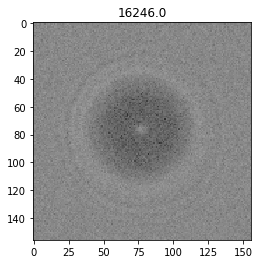

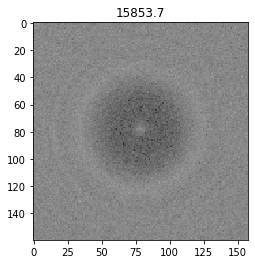

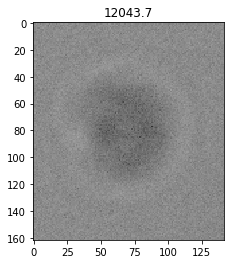

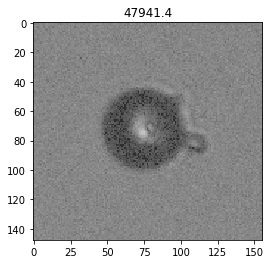

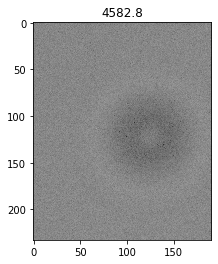

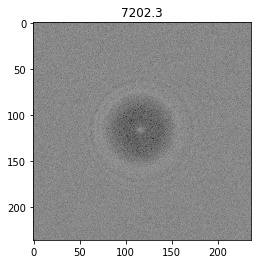

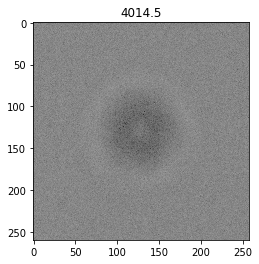

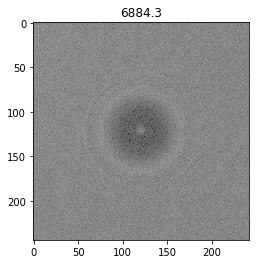

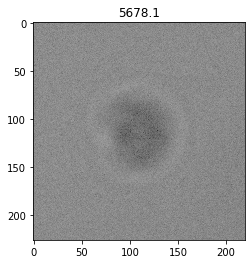

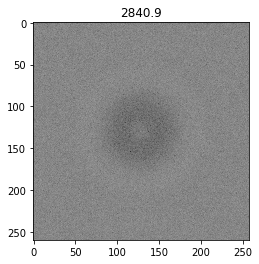

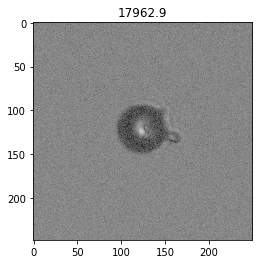

In [50]:
for cut_index,cut in enumerate(cuts):
    plt.figure()
    plt.imshow(cut,cmap='gray',vmin=0,vmax=255)
    #plt.colorbar()
    plt.title('{0:.1f}'.format(metrics[cut_index]))

In [ ]:
thresh

In [ ]:
x_nonzero = np.abs(filtered_x) > 0
y_nonzero = np.abs(filtered_y) > 0
nonzero = np.logical_or(x_nonzero, y_nonzero)
# np.shape(nonzero)
plt.figure(figsize=figsize)
plt.imshow(nonzero, cmap='gray_r')

In [ ]:
print(np.shape(src))
print(np.shape(nonzero))

In [ ]:
_ = plt.plot(np.sum(np.abs(filtered_x)+np.abs(filtered_y), axis=0))
# plt.yscale('log')

In [ ]:
def convolve_img(img, column_conv, row_conv):
    '''https://www.crisluengo.net/archives/150'''

    # first convolve with column_conv (derivative of gaussian)
    # then convolve with row_conv (gaussian)

    return result  # same size as input img, the central part of the convolution

In [ ]:
PATH = os.path.join(os.getcwd(), 'Results_200311/Scans')
file_name = 'minus_3_04-03112020115915-0.png_2_x460_y930_r28_cut2.png'

path_to_image = os.path.join(PATH, file_name)
print(path_to_image)

image = cv2.imread(path_to_image)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(image_gray, cmap='gray')
plt.title('original')


plt.figure()
src = image_gray
ddepth = -1  # same as original
kernel, sigma, cutoff = kernel_from_d(d_um=2.2)
filtered = cv2.filter2D(src, ddepth, kernel)
plt.imshow(filtered, cmap='gray')
plt.colorbar()
plt.title('filtered')


plt.figure()
src = image_gray
ddepth = -1  # same as original
kernel2, sigma2, cutoff = kernel_from_d(d_um=100)
filtered2 = cv2.filter2D(src, ddepth, kernel2)
plt.imshow(filtered2, cmap='gray')
plt.colorbar()
plt.title('filtered2')


plt.figure()
plt.imshow(np.subtract(filtered2, filtered), cmap='gray')
plt.colorbar()
plt.title('filtered2')

In [ ]:
# Maybe normalize for background?

# Calculate kernel for vertical

# Calculate kernel for horizontal

# Calculate vertical profile, apply verical threshold

# Calculate horizontal profile, apply horizontal threshold

# Cut out the overlapping regions

# Rerun the algoritm on these, to check for false positives

# Maybe normalize

# Save cutouts, Report positions, size and values.

# Maybe calculate circle size